# ML Foreclosure Binary Classification - EPOCH 3 data
## SMOTE Oversampling

    target = zeroBalCode (set to object dtype) 
    Binary classification sets zeroBalCode to either "0" or "1" for the 7 possible outcomes
    
    "0" = "Loan Success"
        * 01 = Prepaid or Matured

    "1" =  "Loan Failure" - Most likely loss of money (but not necessarily) one of below conditions:
        * 02 = Third Party Sale
        * 03 = Short Sale
        * 06 = Repurchased
        * 09 = Deed-in-Lieu,REO
        * 15 = Note Sale
        * 16 = Reperforming Loan Sale

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#!pip install pycaret
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from pycaret.classification import *
#from pycaret.regression import *

# Importing the data - only use *.ML.csv files!!!
If you have *.MLReady.csv then [click here](#MLReady)

In [35]:
df=pd.read_csv("data/FM_Acq_Perf_FMAC_EPOCH3_ML.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,id,origChannel,origIntRate,origUPB,origDate,firstPmtDate,origLTV,numBorrowers,...,fmacRateMin,fmacRateAvg,fmacRateVolatility,fredRate,rateDiffAbove,rateDiffBelow,rateDiffAvg,rateDiffAbovePct,rateDiffBelowPct,rateDiffAvgPct
0,1265166,1265166,100495721320,1,4.375,310000,2013-11-01,2014-01-01,64.0,1.0,...,4.16,4.255,0.045673,2.65,0.025,-0.215,0.120,0.005747,-0.051683,0.028202
1,1265167,1265167,102361386857,1,4.625,142000,2013-11-01,2014-01-01,69.0,1.0,...,4.16,4.255,0.045673,2.65,0.275,-0.465,0.370,0.063218,-0.111779,0.086957
2,1265168,1265168,102516953457,1,5.000,124000,2013-11-01,2014-01-01,80.0,1.0,...,4.16,4.255,0.045673,2.65,0.650,-0.840,0.745,0.149425,-0.201923,0.175088
3,1265169,1265169,103711862089,3,4.490,170000,2013-11-01,2014-01-01,54.0,2.0,...,4.16,4.255,0.045673,2.65,0.140,-0.330,0.235,0.032184,-0.079327,0.055229
4,1265170,1265170,104417831957,3,4.750,100000,2013-11-01,2014-01-01,32.0,1.0,...,4.16,4.255,0.045673,2.65,0.400,-0.590,0.495,0.091954,-0.141827,0.116334


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35388 entries, 0 to 35387
Data columns (total 60 columns):
Unnamed: 0                    35388 non-null int64
Unnamed: 0.1                  35388 non-null int64
id                            35388 non-null int64
origChannel                   35388 non-null int64
origIntRate                   35388 non-null float64
origUPB                       35388 non-null int64
origDate                      35388 non-null object
firstPmtDate                  35388 non-null object
origLTV                       35388 non-null float64
numBorrowers                  35388 non-null float64
origDebtIncRatio              35388 non-null float64
borrCreditScore               35388 non-null float64
loanPurp                      35388 non-null int64
zipCode                       35388 non-null int64
pMIperct                      35388 non-null float64
mortInsType                   35388 non-null float64
bestCreditScore               35388 non-null float64
worstC

## Remove columns not involved in 'Foreclosure or Not' query

In [37]:
df.drop(['Unnamed: 0','Unnamed: 0.1','id','firstPmtDate','rptPeriod','currIntRate','currUPB','loanAge','monMatur',\
         'zeroBalDate','lastPdInstDate','forecloDate','dispDate','forecloCost','propRepCost','recovCosts',\
         'miscCost','holdTaxCost','saleProceed','credEnhProceed','repurchProceed','otherForecloProceed',\
         'nonIntUPB','prinForgivBal','repurchMakeWholeProceedFlg','forecloPrinWriteOffAmnt','servActivIndicator',\
         'deliqGood','deliqBad','deliqMax'],1,inplace=True)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35388 entries, 0 to 35387
Data columns (total 30 columns):
origChannel           35388 non-null int64
origIntRate           35388 non-null float64
origUPB               35388 non-null int64
origDate              35388 non-null object
origLTV               35388 non-null float64
numBorrowers          35388 non-null float64
origDebtIncRatio      35388 non-null float64
borrCreditScore       35388 non-null float64
loanPurp              35388 non-null int64
zipCode               35388 non-null int64
pMIperct              35388 non-null float64
mortInsType           35388 non-null float64
bestCreditScore       35388 non-null float64
worstCreditScore      35388 non-null float64
avgCreditScore        35388 non-null float64
bankNumber            35388 non-null int64
stateNumber           35388 non-null int64
mSA                   35388 non-null int64
zeroBalCode           35388 non-null float64
fmacRateMax           35388 non-null float64
fmacRa

## Engineer originDate into Date features

In [39]:
df['origDate'] = pd.to_datetime(df['origDate'])

In [40]:
df['origYear'] = df['origDate'].dt.year
df['origMonth'] = df['origDate'].dt.month

In [41]:
df.drop(['origDate'],1,inplace=True)

In [42]:
df[['origYear','origMonth']].tail()

,origYear,origMonth
35383,2019,3
35384,2019,3
35385,2019,3
35386,2019,3
35387,2019,3


# Turn zero Balance Code Into binary "0" GOOD and "1" BAD

In [43]:
df.zeroBalCode.unique()

array([ 1.,  9., 16.,  3.,  2.,  6., 15.])

In [44]:
df['zeroBalCode'] = df.zeroBalCode.replace(1,0)
df['zeroBalCode'] = df.zeroBalCode.replace([9,3,16,6,2,15],1)

In [45]:
df.zeroBalCode.unique()

array([0., 1.])

In [46]:
#Checking datatypes of individual feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35388 entries, 0 to 35387
Data columns (total 31 columns):
origChannel           35388 non-null int64
origIntRate           35388 non-null float64
origUPB               35388 non-null int64
origLTV               35388 non-null float64
numBorrowers          35388 non-null float64
origDebtIncRatio      35388 non-null float64
borrCreditScore       35388 non-null float64
loanPurp              35388 non-null int64
zipCode               35388 non-null int64
pMIperct              35388 non-null float64
mortInsType           35388 non-null float64
bestCreditScore       35388 non-null float64
worstCreditScore      35388 non-null float64
avgCreditScore        35388 non-null float64
bankNumber            35388 non-null int64
stateNumber           35388 non-null int64
mSA                   35388 non-null int64
zeroBalCode           35388 non-null float64
fmacRateMax           35388 non-null float64
fmacRateMin           35388 non-null float64
fmacR

# Review values for dates and slice (if needed) the timeframe you want

In [47]:
df.origYear.unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019], dtype=int64)

In [48]:
df['origMonth'].unique()

array([11, 12,  1,  2,  3,  5,  4,  6,  7,  9,  8, 10], dtype=int64)

# Coerce the column dtype (int in this case)

In [49]:
df = df.astype({'origLTV':'int','numBorrowers':'int','origDebtIncRatio':'int',\
               'borrCreditScore':'int','mortInsType':'int','bestCreditScore':'int',\
               'worstCreditScore':'int','avgCreditScore':'int','zeroBalCode':'int'})
#,'zeroBalCode':'int'

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35388 entries, 0 to 35387
Data columns (total 31 columns):
origChannel           35388 non-null int64
origIntRate           35388 non-null float64
origUPB               35388 non-null int64
origLTV               35388 non-null int32
numBorrowers          35388 non-null int32
origDebtIncRatio      35388 non-null int32
borrCreditScore       35388 non-null int32
loanPurp              35388 non-null int64
zipCode               35388 non-null int64
pMIperct              35388 non-null float64
mortInsType           35388 non-null int32
bestCreditScore       35388 non-null int32
worstCreditScore      35388 non-null int32
avgCreditScore        35388 non-null int32
bankNumber            35388 non-null int64
stateNumber           35388 non-null int64
mSA                   35388 non-null int64
zeroBalCode           35388 non-null int32
fmacRateMax           35388 non-null float64
fmacRateMin           35388 non-null float64
fmacRateAvg           3

<a id='MLReady'></a>

<a id='MLReady'></a>
## *MLReady.csv file loading point
uncomment one of the boxes below

In [51]:
#df.to_csv('D:\FM_FULL_EPOCH3_MLReady.csv')

In [52]:
#df = pd.read_csv('D:\FM_FULL_EPOCH2_MLReady.csv')

# Oversampling (Since we are starting with only 17.2% of our predicted class)

In [54]:
good = df.zeroBalCode.value_counts()[0]
bad = df.zeroBalCode.value_counts()[1]
perct_bad = round(good/bad,2)
print(f'We have {perct_bad}% Foreclosures in our dataset')

We have 17.17% Foreclosures in our dataset


In [55]:
training_features, test_features, \
training_target, test_target, = train_test_split(
    df.drop(['zeroBalCode'], axis=1)
    , df['zeroBalCode']
    , test_size = .1
    , random_state=12
)

In [22]:
# Further split the training data into training/validation
x_train, x_val, y_train, y_val = train_test_split(
    training_features
    , training_target
    , test_size = .1
    ,random_state=12
)

In [24]:
# For the training data, randomly sample 
ros = RandomOverSampler(sampling_strategy=0.2)
x_train_res, y_train_res = ros.fit_sample(x_train, y_train)

In [57]:
print('#############################################')
print('Before oversampling: "Closed" crushes "Default" and causes issues:')
print(training_target.value_counts())
print('')
print(y_val.value_counts())
print('')
print('After oversampling: "Closed" and "Default" are equal')
print(y_train_res.value_counts())

#############################################
Before oversampling: "Closed" crushes "Default" and causes issues:
0    30081
1     1768
Name: zeroBalCode, dtype: int64

0    3004
1     181
Name: zeroBalCode, dtype: int64

After oversampling: "Closed" and "Default" are equal
0    27077
1     5415
Name: zeroBalCode, dtype: int64


# Recombine X_train_res, y_train_res so PyCaret can deal with one df

In [26]:
y_train_res.shape

(32492,)

In [27]:
df = x_train_res.copy()

In [28]:
df['zeroBalCode'] = y_train_res

In [29]:
df.shape

(32492, 31)

# Review metrics last time before run (to have record of starting values)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32492 entries, 0 to 32491
Data columns (total 31 columns):
origChannel           32492 non-null int64
origIntRate           32492 non-null float64
origUPB               32492 non-null int64
origLTV               32492 non-null int32
numBorrowers          32492 non-null int32
origDebtIncRatio      32492 non-null int32
borrCreditScore       32492 non-null int32
loanPurp              32492 non-null int64
zipCode               32492 non-null int64
pMIperct              32492 non-null float64
mortInsType           32492 non-null int32
bestCreditScore       32492 non-null int32
worstCreditScore      32492 non-null int32
avgCreditScore        32492 non-null int32
bankNumber            32492 non-null int64
stateNumber           32492 non-null int64
mSA                   32492 non-null int64
fmacRateMax           32492 non-null float64
fmacRateMin           32492 non-null float64
fmacRateAvg           32492 non-null float64
fmacRateVolatility   

In [32]:
pd.set_option('max_columns',None)
df.head()

,origChannel,origIntRate,origUPB,origLTV,numBorrowers,origDebtIncRatio,borrCreditScore,loanPurp,zipCode,pMIperct,mortInsType,bestCreditScore,worstCreditScore,avgCreditScore,bankNumber,stateNumber,mSA,fmacRateMax,fmacRateMin,fmacRateAvg,fmacRateVolatility,fredRate,rateDiffAbove,rateDiffBelow,rateDiffAvg,rateDiffAbovePct,rateDiffBelowPct,rateDiffAvgPct,origYear,origMonth,zeroBalCode
0,2,4.250,206000,80,2,32,751,2,750,0.0,0,751,712,731,54,45,19100,3.91,3.86,3.890,0.012953,2.17,0.340,-0.390,0.360,0.086957,-0.101036,0.092545,2015,9,0
1,1,4.250,205000,65,1,25,692,1,925,0.0,0,692,692,692,80,4,40140,3.73,3.63,3.670,0.027548,2.17,0.520,-0.620,0.580,0.139410,-0.170799,0.158038,2015,1,0
2,3,4.125,295000,69,1,44,691,2,946,0.0,0,691,691,691,17,4,41860,3.70,3.65,3.672,0.013699,1.87,0.425,-0.475,0.453,0.114865,-0.130137,0.123366,2015,4,0
3,1,4.750,475000,76,2,30,638,2,906,0.0,0,638,637,637,39,4,31080,3.48,3.41,3.440,0.020528,1.46,1.270,-1.340,1.310,0.364943,-0.392962,0.380814,2016,7,0
4,1,4.500,85000,46,2,35,637,1,570,0.0,0,639,637,638,66,43,0,4.09,3.98,4.046,0.027638,2.43,0.410,-0.520,0.454,0.100244,-0.130653,0.112210,2015,7,0


# Pycaret - Setup with categorical definition

### Use complex setup 

In [33]:
model_setup = setup(
    df
    , target = 'zeroBalCode' # PyCaret will list this as "Label"
    , pca = False 
    , ignore_low_variance = True # Variance is calculated using the ratio of unique values to the number of samples, and the ratio of the most common value to the frequency of the second most common value.
    , normalize = True
    , ignore_features = None
    , handle_unknown_categorical = True
    , remove_outliers = True # outliers from the training data are removed using PCA linear dimensionality reduction using the Singular Value Decomposition technique.
    , bin_numeric_features = [
            'origIntRate'
            , 'origUPB'
            , 'origLTV'
            , 'origDebtIncRatio'
            , 'bestCreditScore'
            , 'avgCreditScore'
            , 'worstCreditScore'
        ] # Set to True to bin numerics using K Means
    , feature_selection = True
    , silent = True
    , profile = False
    , categorical_features = [
            'origChannel'
            , 'numBorrowers'
            , 'loanPurp'
            , 'zipCode'
            , 'bankNumber'
            , 'stateNumber'
            , 'origYear'
            , 'origMonth'
            , 'mSA'
        ]
        , numeric_features = [
            'origIntRate'
            , 'origUPB'
            , 'origLTV'
            , 'pMIperct'
            , 'origDebtIncRatio'
            , 'worstCreditScore'
            , 'bestCreditScore'
            , 'avgCreditScore'
            , 'rateDiffAbove'
            , 'rateDiffBelow'
            , 'rateDiffAvg'
            , 'rateDiffAbovePct'
            , 'rateDiffBelowPct'
            , 'rateDiffAvgPct'
        ]
)


 
Setup Succesfully Completed!


,Description,Value
0,session_id,1155
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(32492, 31)"
4,Missing Values,False
5,Numeric Features,21
6,Categorical Features,9
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


## Compare Models with no blacklist exclusions

In [32]:
model_results=compare_models() #blacklist = ['tr','ransac'],'lar','par','huber','llar','lasso','en','ridge','omp','br','svm'])
model_results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extra Trees Classifier,0.9986,1,1,0.9972,0.9986,0.9972
1,Random Forest Classifier,0.9916,1,0.9998,0.9841,0.9919,0.9833
2,Decision Tree Classifier,0.9506,0.9495,1,0.9118,0.9539,0.9009
3,CatBoost Classifier,0.9144,0.9689,0.9734,0.8735,0.9207,0.8283
4,K Neighbors Classifier,0.8985,0.9621,0.9996,0.8344,0.9096,0.796
5,Light Gradient Boosting Machine,0.8685,0.9379,0.9294,0.8326,0.8783,0.7362
6,SVM - Linear Kernel,0.802,0,0.8323,0.7915,0.8111,0.6034
7,Linear Discriminant Analysis,0.8009,0.8744,0.8328,0.7891,0.8103,0.6012
8,Ridge Classifier,0.7996,0,0.8314,0.788,0.8091,0.5985
9,Logistic Regression,0.7984,0.8699,0.8268,0.7887,0.8073,0.5961


## Create models 

### Extra Trees Classifier

In [33]:
et = create_model('et', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9986,1.0,1.0,0.9973,0.9986,0.9972
1,0.9997,1.0,1.0,0.9995,0.9997,0.9994
2,0.9972,1.0,1.0,0.9946,0.9973,0.9944
3,0.9994,1.0,1.0,0.9989,0.9995,0.9989
4,0.9989,1.0,1.0,0.9978,0.9989,0.9978
5,0.9981,1.0,1.0,0.9962,0.9981,0.9961
6,0.9994,1.0,1.0,0.9989,0.9995,0.9989
7,0.9975,1.0,1.0,0.9951,0.9976,0.9950
8,0.9983,1.0,1.0,0.9967,0.9984,0.9967
9,0.9986,1.0,1.0,0.9973,0.9986,0.9972


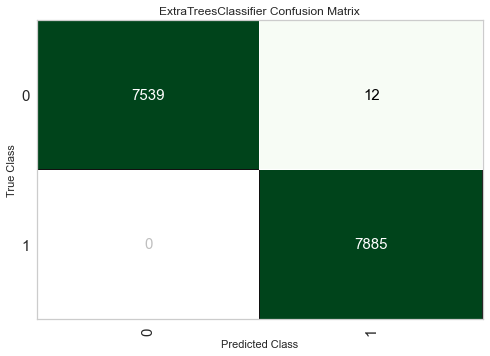

In [44]:
plot_model(et, plot = 'confusion_matrix')

### Extra Trees Classifier just guessed everything beyond belief really

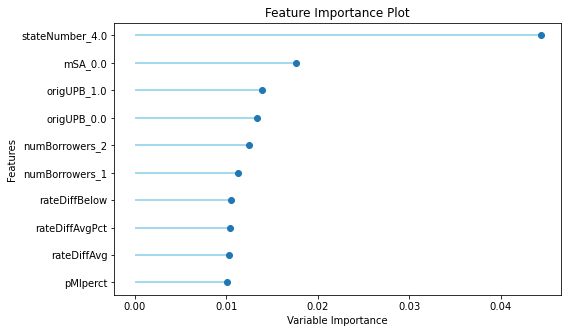

In [41]:
plot_model(et, plot = 'feature')

#### CatBoost

In [34]:
#catboost =create_model('catboost', fold = 10)

#### Light Gradient Boosting Machine (lgbm)

In [79]:
lightgbm = create_model('lightgbm', fold = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8609,0.9341,0.9277,0.8227,0.8720,0.7209
1,0.8706,0.9428,0.9408,0.8290,0.8814,0.7404
2,0.8670,0.9373,0.9342,0.8276,0.8777,0.7332
3,0.8770,0.9405,0.9473,0.8344,0.8872,0.7532
4,0.8592,0.9329,0.9130,0.8288,0.8689,0.7176
5,0.8745,0.9386,0.9288,0.8418,0.8831,0.7483
6,0.8775,0.9429,0.9386,0.8403,0.8867,0.7543
7,0.8650,0.9344,0.9184,0.8341,0.8742,0.7294
8,0.8664,0.9369,0.9222,0.8338,0.8758,0.7321
9,0.8667,0.9386,0.9233,0.8336,0.8762,0.7327


## Tune Models

#### Tuned Light GBM

In [80]:
tuned_lightgbm = tune_model('lightgbm') # fold=10

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9686,0.9966,1.0000,0.9421,0.9702,0.9371
1,0.9672,0.9975,1.0000,0.9397,0.9689,0.9344
2,0.9689,0.9948,1.0000,0.9426,0.9705,0.9377
3,0.9717,0.9965,1.0000,0.9475,0.9730,0.9433
4,0.9675,0.9975,1.0000,0.9402,0.9692,0.9349
5,0.9678,0.9967,0.9989,0.9416,0.9694,0.9355
6,0.9689,0.9982,1.0000,0.9426,0.9704,0.9377
7,0.9686,0.9963,1.0000,0.9421,0.9702,0.9371
8,0.9675,0.9960,1.0000,0.9402,0.9692,0.9349
9,0.9728,0.9966,1.0000,0.9494,0.9740,0.9455


### LigthGBM had marked improvements on all metrics!!
#### Improved:  Accuracy AUC   Recall    Precision F1   Kappa
#### Declined: 
                    Accuracy	 AUC	 Recall	 Prec.	  F1	    Kappa
    Untuned:  Mean	0.8685	0.9379	0.9294	0.8326	0.8783	0.7362
    Tuned:    Mean	0.9690	0.9967	0.9999	0.9428	0.9705	0.9378

In [39]:
#plot_model(tuned_lightgbm, plot = 'vc')

#### Tuned CatBoost

In [36]:
#tuned_catboost = tune_model('catboost') # from fold=50

### CatBoost had marked improvements on all metrics!!
#### Improved:  Accuracy AUC   Recall    Precision F1   Kappa
#### Declined:     
                    Accuracy	 AUC	 Recall	 Prec.	  F1	    Kappa
    Untuned:  Mean	0.7693	0.8472	0.8259	0.7417	0.7815	0.5386
    Tuned:    Mean	0.8567	0.9280	0.9240	0.8142	0.8656	0.7134

### Let's see if we can improve with more folds set at 50

In [38]:
#tuned_lightgbm50 = tune_model('lightgbm', fold=50) # fold = 50

### LigthGBM continued to improve on all metrics!!
#### Improved:  Accuracy AUC   Recall    Precision F1   Kappa
#### Declined: 
                    Accuracy	 AUC	 Recall	 Prec.	  F1	    Kappa
    Untuned:  Mean	0.7436	0.8209	0.8035	0.7172	0.7579	0.4872
    Tuned10:  Mean	0.8648	0.9298	0.9314	0.8217	0.8731	0.7296
    Tuned50:  Mean	0.8723	0.9372	0.9393	0.8283	0.8803	0.7447

### Let's see if we can improve with more folds set at 100

In [40]:
#tuned_lightgbm100 = tune_model('lightgbm', fold=100) # fold = 50

### LigthGBM continued to improve on all metrics!!
#### Improved:  Accuracy AUC   Recall    Precision F1   Kappa
#### Declined: 
                    Accuracy	 AUC	 Recall	 Prec.	  F1	    Kappa
    Untuned:  Mean	0.7436	0.8209	0.8035	0.7172	0.7579	0.4872
    Tuned10:  Mean	0.8648	0.9298	0.9314	0.8217	0.8731	0.7296
    Tuned50:  Mean	0.8723	0.9372	0.9393	0.8283	0.8803	0.7447
    Tuned100: Mean	0.8739	0.9383	0.9399	0.8303	0.8816	0.7477

In [42]:
#plot_model(tuned_lightgbm100, plot = 'feature')

#### XGBoost

In [38]:
#tuned_xgboost = tune_model('xgboost')

Didn't tune xgboost since it takes about 5 hours and I don't see a big benefit tuning the above models

## Ensemble models

In [39]:
#catboost_bagged = ensemble_model(catboost)

### CatBoost had great improvements with Ensemble Bagging
#### Improved:  Accuracy   AUC   Recall   F1   Kappa
#### Declined:   Precision    
                    Accuracy	 AUC	 Recall	 Prec.	  F1	    Kappa
    Untuned:  Mean	0.8661	0.7938	0.0730	0.5686	0.1293	0.1014
    Bagging:  Mean	0.8664	0.7972	0.0837	0.5637	0.1456	0.1145

In [40]:
#catboost_boosted = ensemble_model(catboost)

## Blend 3 chosen Models

#### First blend 'non-tuned' models

In [41]:
#blend3 = blend_models(estimator_list = [catboost, lightgbm, xgboost])

#### Next blend tuned models

# Evaluate Models

## Extra Trees Classifier ("Fast Set" - some plots take longer and they are commented out

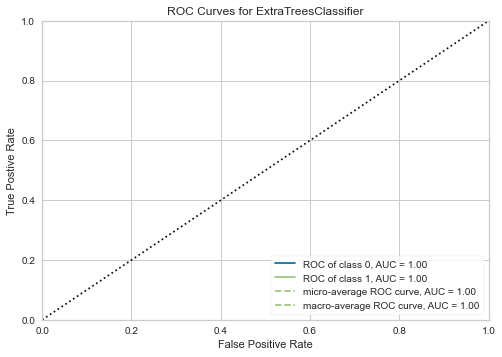

In [45]:
plot_model(et) #Super Fast

In [46]:
#plot_model(et, plot = 'threshold') #Medium Speed

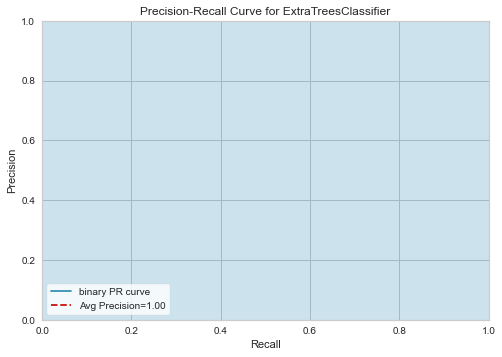

In [47]:
plot_model(et, plot = 'pr')  #Super Fast

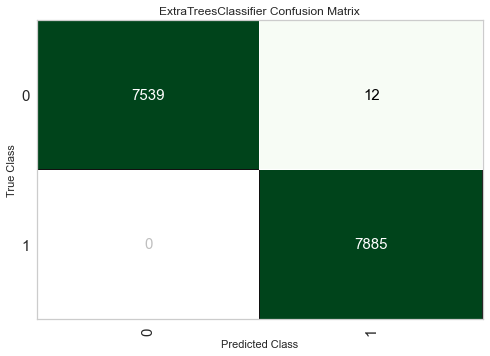

In [43]:
plot_model(et, plot='confusion_matrix') #Super Fast

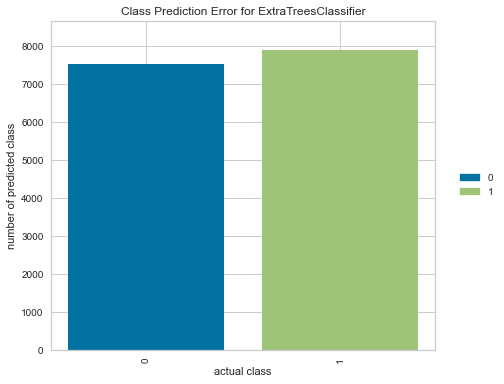

In [48]:
plot_model(et, plot = 'error') #Super Fast

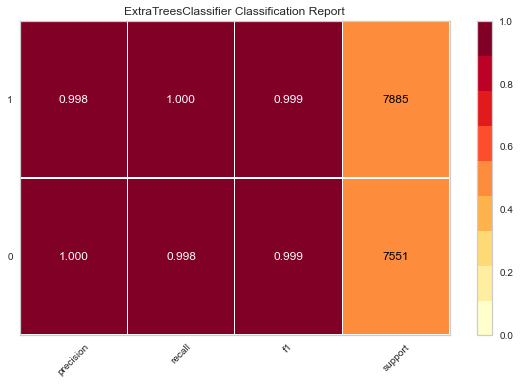

In [49]:
plot_model(et, plot = 'class_report') #Super Fast

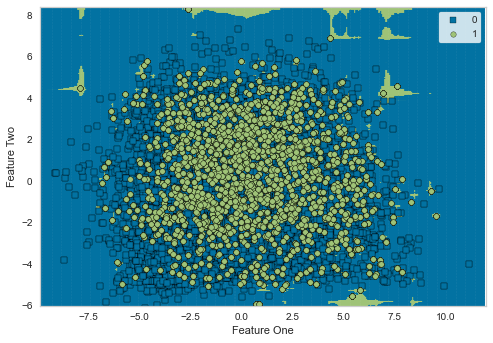

In [50]:
plot_model(et, plot = 'boundary') #Super Fast

In [51]:
#plot_model(et, plot='learning') #Slow

In [52]:
#plot_model(et, plot = 'calibration') #Very Very Slow

In [53]:
#plot_model(et,, plot = 'vc') #Very Slow

In [54]:
#plot_model(et, plot='dimension')  # Slow

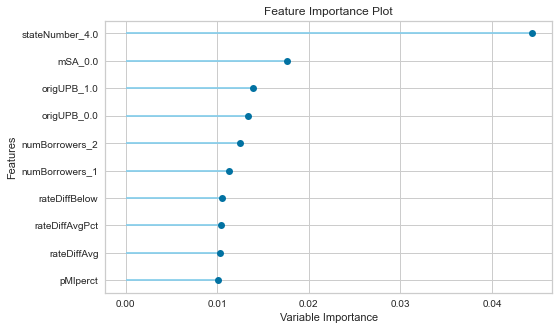

In [55]:
plot_model(et, plot = 'feature') #Super Fast

In [56]:
plot_model(et, plot = 'parameter') #Super Fast

,Parameters
bootstrap,False
ccp_alpha,0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0
min_impurity_split,None


## Light GBM ("Fast Set" - some plots take longer and they are commented out

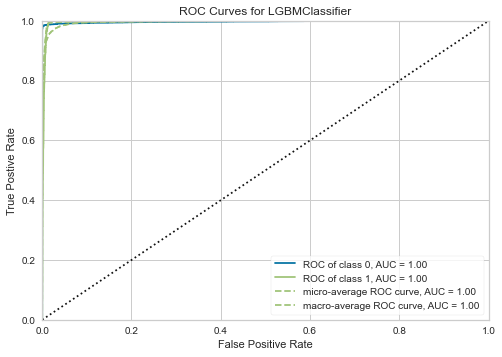

In [94]:
plot_model(tuned_lightgbm) #Super Fast

In [95]:
#plot_model(tuned_lightgbm, plot = 'threshold') #Medium Speed

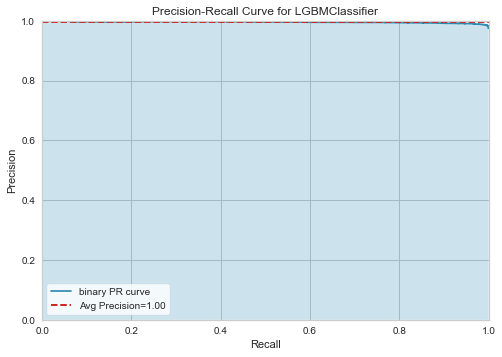

In [96]:
plot_model(tuned_lightgbm, plot = 'pr')  #Super Fast

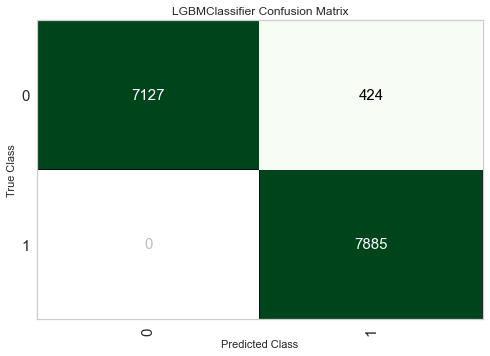

In [97]:
plot_model(tuned_lightgbm, plot='confusion_matrix') #Super Fast

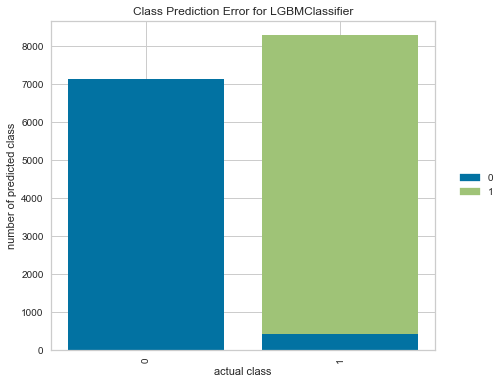

In [98]:
plot_model(tuned_lightgbm, plot = 'error') #Super Fast

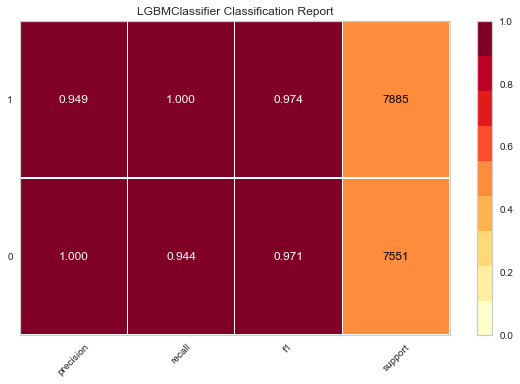

In [99]:
plot_model(tuned_lightgbm, plot = 'class_report') #Super Fast

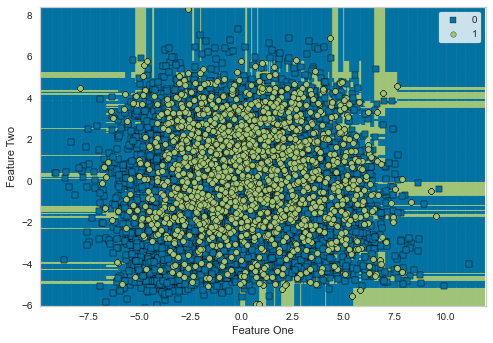

In [100]:
plot_model(tuned_lightgbm, plot = 'boundary') #Super Fast

In [101]:
#plot_model(tuned_lightgbm, plot='learning') #Slow

In [102]:
#plot_model(tuned_lightgbm, plot = 'calibration') #Very Very Slow

In [103]:
#plot_model(tuned_lightgbm,, plot = 'vc') #Very Slow

In [104]:
#plot_model(tuned_lightgbm, plot='dimension')  # Slow

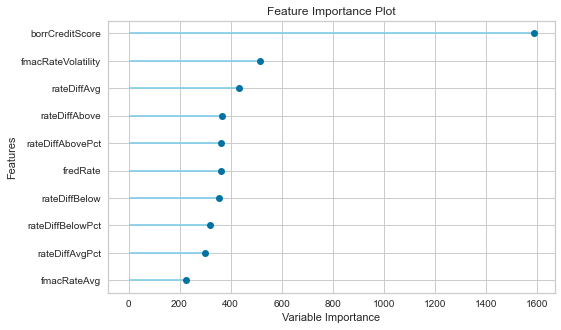

In [105]:
plot_model(tuned_lightgbm, plot = 'feature') #Super Fast

In [107]:
plot_model(tuned_lightgbm, plot = 'parameter') #Super Fast

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1
importance_type,split
learning_rate,0.4
max_depth,30
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.1
n_estimators,170


In [42]:
#blendTuned3 = blend_models(estimator_list = [tuned_catboost, tuned_lightgbm, tuned_xgboost])

# Interpret Models

## Extra Tree Classifier (et)

In [ ]:
#interpret_model(et plot = 'summary')

In [ ]:
#interpret_model(et, plot='correlation', feature='avgCreditScore')

# Predict models using the "Oversampled" test holdout within PyCaret

#### CatBoost

In [57]:
pred_holdout = predict_model(et)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extra Trees Classifier,0.9992,1.0,1.0,0.9985,0.9992,0.9984


#### Tuned CatBoost

In [82]:
#pred_holdout_tuned = predict_model(tuned_catboost)

#### Light GBM

In [83]:
pred_holdout = predict_model(lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Light Gradient Boosting Machine,0.8687,0.9388,0.9226,0.8371,0.8778,0.7368


#### Tuned Light GBM

In [84]:
pred_holdout_tuned = predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Light Gradient Boosting Machine,0.9725,0.9971,1.0,0.949,0.9738,0.945


# The golden moment... put 10% sample test data through the models...

# Recombine test_features, test_target at first train/test/split
 This "test" set was split BEFORE Oversampling. PyCaret takes the "train" from this split and splits it internally again. Since we have no control of how PyCaret does this we needed to do a train/test split before we input the training set into PyCaret. Now we will recombine the test_features and test_target into one new df

In [108]:
test_features.shape

(3539, 30)

In [109]:
test_target.shape

(3539,)

In [110]:
test_df = test_features.copy()

In [111]:
test_df['zeroBalCode'] = test_target

In [112]:
test_df.shape

(3539, 31)

In [113]:
totalTestCount = test_df.zeroBalCode.value_counts().sum()
posTestCount = test_df.zeroBalCode.value_counts()[1]
print('#############################################')
print('This "Test" set has not been oversamplied')
print(test_df.zeroBalCode.value_counts())
print(f'Positive samples are {round(posTestCount/totalTestCount*100,2)}%')

#############################################
This "Test" set has not been oversamplied
0    3359
1     180
Name: zeroBalCode, dtype: int64
Positive samples are 5.09%


# Recombine validation features / targets x_val, y_val
 This "validation" set was split BEFORE Oversampling. PyCaret takes the "train" from this split and splits it internally again. Since we have no control of how PyCaret does this we needed to do a train/validation split before we input the training set into PyCaret. Now we will recombine the test_features and test_target into one new df

In [56]:
x_val.shape

(3185, 30)

In [58]:
y_val.shape

(3185,)

In [59]:
validation_df = x_val.copy()

In [60]:
validation_df['zeroBalCode'] = y_val

In [61]:
validation_df.shape

(3185, 31)

In [64]:
totalTestCount = validation_df.zeroBalCode.value_counts().sum()
posTestCount = validation_df.zeroBalCode.value_counts()[1]
print('#############################################')
print('This "Validation" set has not been oversamplied')
print(validation_df.zeroBalCode.value_counts())
print(f'Positive samples are {round(posTestCount/totalTestCount*100,2)}%')

#############################################
This "Validation" set has not been oversamplied
0    3004
1     181
Name: zeroBalCode, dtype: int64
Positive samples are 5.68%


## Create function for confusion matrix

In [71]:
def calc_confusion(row):
    if ((row['zeroBalCode'] == 0) & (row['Label'] == 0)):
        value = 'TrueNegative'
    elif ((row['zeroBalCode'] == 0) & (row['Label'] == 1)):
        value = 'FalseNegative'
    elif ((row['zeroBalCode'] == 1) & (row['Label'] == 1)):
        value = 'TruePositive'
    elif ((row['zeroBalCode'] == 1) & (row['Label'] == 0)):
        value = 'FalsePositive'
    else:
        value = 'Undefined'
    return value

# Extra Trees Classifier

In [67]:
predictions = predict_model(et, data=test_df)

In [68]:
pd.set_option('max_columns',None)
predictions.head()

,origChannel,origIntRate,origUPB,origLTV,numBorrowers,origDebtIncRatio,borrCreditScore,loanPurp,zipCode,pMIperct,mortInsType,bestCreditScore,worstCreditScore,avgCreditScore,bankNumber,stateNumber,mSA,fmacRateMax,fmacRateMin,fmacRateAvg,fmacRateVolatility,fredRate,rateDiffAbove,rateDiffBelow,rateDiffAvg,rateDiffAbovePct,rateDiffBelowPct,rateDiffAvgPct,origYear,origMonth,zeroBalCode,Label,Score
0,3,4.375,236000,60,1,45,671,1,900,0.0,0,671,671,671,1,4,31080,3.97,3.79,3.8725,0.047493,2.27,0.405,-0.585,0.5025,0.102015,-0.154354,0.129761,2016,1,0,0,0.15
1,1,4.250,264000,84,1,31,728,2,17,12.0,2,728,728,728,54,20,14460,3.87,3.80,3.8400,0.018421,2.12,0.380,-0.450,0.4100,0.098191,-0.118421,0.106771,2015,5,0,0,0.19
2,1,3.990,626000,77,1,44,745,1,968,0.0,0,745,745,745,66,12,46520,3.64,3.57,3.6000,0.019608,1.83,0.350,-0.420,0.3900,0.096154,-0.117647,0.108333,2016,5,0,0,0.08
3,3,4.250,305000,79,1,45,716,1,917,0.0,0,716,716,716,80,4,40140,3.70,3.65,3.6720,0.013699,1.87,0.550,-0.600,0.5780,0.148649,-0.164384,0.157407,2015,4,0,0,0.14
4,1,4.000,250000,80,2,34,797,1,850,0.0,0,797,787,792,54,3,38060,3.94,3.84,3.9050,0.026042,2.20,0.060,-0.160,0.0950,0.015228,-0.041667,0.024328,2015,8,0,0,0.02


In [69]:
results = predictions[['zeroBalCode','Label','Score']]

In [70]:
predictions.Label.value_counts()

0    3514
1      25
Name: Label, dtype: int64

In [72]:
results['Confusion'] = results.apply(calc_confusion, axis=1)

In [73]:
confusionMatrix = results.Confusion.value_counts().to_dict()

In [78]:
print(f'           ##############################')
print(f'           #             #              #')
print(f'         0 #    {confusionMatrix["TrueNegative"]}     #     {confusionMatrix["FalsePositive"]}      #')
print(f'  True     #             #              #')
print(f'  Class    ##############################')
print(f'           #             #              #')
print(f'         1 #    {confusionMatrix["FalseNegative"]}       #     {confusionMatrix["TruePositive"]}       #')
print(f'           #             #              #')
print(f'           ##############################')
print(f'                  0              1        ')
print(f'                  Predicted Class           ')

           ##############################
           #             #              #
         0 #    3345     #     169      #
  True     #             #              #
  Class    ##############################
           #             #              #
         1 #    14       #     11       #
           #             #              #
           ##############################
                  0              1        
                  Predicted Class           


In [75]:
# 0 or 2 = Predict equals truth, 1 = Predict doesn't equal truth
totalNegative = confusionMatrix['TrueNegative'] + confusionMatrix['FalseNegative']
totalPositive = confusionMatrix['TruePositive'] + confusionMatrix['FalsePositive']
trueNegativePct = confusionMatrix['TrueNegative'] / totalNegative * 100
falseNegativePct = confusionMatrix['FalseNegative'] / totalNegative * 100
truePositivePct = confusionMatrix['TruePositive'] / totalPositive * 100
falsePositivePct = confusionMatrix['FalsePositive'] / totalPositive * 100

print(f'TrueNegative:  {round(trueNegativePct,2)}%')
print(f'FalseNegative:  {round(falseNegativePct,2)}%')
print(f'TruePosiive:   {round(truePositivePct,2)}%')
print(f'FalsePositive: {round(falsePositivePct,2)}%')

TrueNegative:  99.58%
FalseNegative:  0.42%
TruePosiive:   6.11%
FalsePositive: 93.89%


#### Well this is disappointing... The non-oversampled test dataset performed worse than random flipping a coin!

In [76]:
#save_model(ett, 'tunedCatboost_EPOCH2_Over50_50_052520')

# Tuned Light GBM Fold = 10

In [114]:
predictions = predict_model(tuned_lightgbm, data=test_df)

In [115]:
pd.set_option('max_columns',None)
predictions.head()

,origChannel,origIntRate,origUPB,origLTV,numBorrowers,origDebtIncRatio,borrCreditScore,loanPurp,zipCode,pMIperct,mortInsType,bestCreditScore,worstCreditScore,avgCreditScore,bankNumber,stateNumber,mSA,fmacRateMax,fmacRateMin,fmacRateAvg,fmacRateVolatility,fredRate,rateDiffAbove,rateDiffBelow,rateDiffAvg,rateDiffAbovePct,rateDiffBelowPct,rateDiffAvgPct,origYear,origMonth,zeroBalCode,Label,Score
0,3,4.375,236000,60,1,45,671,1,900,0.0,0,671,671,671,1,4,31080,3.97,3.79,3.8725,0.047493,2.27,0.405,-0.585,0.5025,0.102015,-0.154354,0.129761,2016,1,0,0,0.1326
1,1,4.250,264000,84,1,31,728,2,17,12.0,2,728,728,728,54,20,14460,3.87,3.80,3.8400,0.018421,2.12,0.380,-0.450,0.4100,0.098191,-0.118421,0.106771,2015,5,0,1,0.6123
2,1,3.990,626000,77,1,44,745,1,968,0.0,0,745,745,745,66,12,46520,3.64,3.57,3.6000,0.019608,1.83,0.350,-0.420,0.3900,0.096154,-0.117647,0.108333,2016,5,0,0,0.0345
3,3,4.250,305000,79,1,45,716,1,917,0.0,0,716,716,716,80,4,40140,3.70,3.65,3.6720,0.013699,1.87,0.550,-0.600,0.5780,0.148649,-0.164384,0.157407,2015,4,0,0,0.3047
4,1,4.000,250000,80,2,34,797,1,850,0.0,0,797,787,792,54,3,38060,3.94,3.84,3.9050,0.026042,2.20,0.060,-0.160,0.0950,0.015228,-0.041667,0.024328,2015,8,0,0,0.0252


In [116]:
results = predictions[['zeroBalCode','Label','Score']]

In [117]:
predictions.Label.value_counts()

0    3109
1     430
Name: Label, dtype: int64

In [118]:
def calc_confusion(row):
    if ((row['zeroBalCode'] == 0) & (row['Label'] == 0)):
        value = 'TrueNegative'
    elif ((row['zeroBalCode'] == 0) & (row['Label'] == 1)):
        value = 'FalseNegative'
    elif ((row['zeroBalCode'] == 1) & (row['Label'] == 1)):
        value = 'TruePositive'
    elif ((row['zeroBalCode'] == 1) & (row['Label'] == 0)):
        value = 'FalsePositive'
    else:
        value = 'Undefined'
    return value

In [119]:
results['Confusion'] = results.apply(calc_confusion, axis=1)

In [120]:
confusionMatrix = results.Confusion.value_counts().to_dict()

In [123]:
print(f'           ##############################')
print(f'           #             #              #')
print(f'         0 #    {confusionMatrix["TrueNegative"]}     #     {confusionMatrix["FalsePositive"]}      #')
print(f'  True     #             #              #')
print(f'  Class    ##############################')
print(f'           #             #              #')
print(f'         1 #    {confusionMatrix["FalseNegative"]}      #     {confusionMatrix["TruePositive"]}       #')
print(f'           #             #              #')
print(f'           ##############################')
print(f'                  0              1        ')
print(f'                  Predicted Class           ')

           ##############################
           #             #              #
         0 #    2986     #     123      #
  True     #             #              #
  Class    ##############################
           #             #              #
         1 #    373      #     57       #
           #             #              #
           ##############################
                  0              1        
                  Predicted Class           


In [122]:
# 0 or 2 = Predict equals truth, 1 = Predict doesn't equal truth
totalNegative = confusionMatrix['TrueNegative'] + confusionMatrix['FalseNegative']
totalPositive = confusionMatrix['TruePositive'] + confusionMatrix['FalsePositive']
trueNegativePct = confusionMatrix['TrueNegative'] / totalNegative * 100
falseNegativePct = confusionMatrix['FalseNegative'] / totalNegative * 100
truePositivePct = confusionMatrix['TruePositive'] / totalPositive * 100
falsePositivePct = confusionMatrix['FalsePositive'] / totalPositive * 100

print(f'TrueNegative:  {round(trueNegativePct,2)}%')
print(f'FalseNegative:  {round(falseNegativePct,2)}%')
print(f'TruePosiive:   {round(truePositivePct,2)}%')
print(f'FalsePositive: {round(falsePositivePct,2)}%')

TrueNegative:  88.9%
FalseNegative:  11.1%
TruePosiive:   31.67%
FalsePositive: 68.33%


#### Well this is disappointing... The non-oversampled test dataset performed worse than random flipping a coin!

In [120]:
#save_model(tuned_lightgbm, 'tunedLGBM_EPOCH2_Over50_50_052520')

Transformation Pipeline and Model Succesfully Saved


# Tuned Light GBM Fold = 100

In [140]:
predictions = predict_model(tuned_lightgbm100, data=test_df)

In [141]:
pd.set_option('max_columns',None)
predictions.head()

,origChannel,origIntRate,origUPB,origLTV,numBorrowers,origDebtIncRatio,borrCreditScore,loanPurp,zipCode,pMIperct,mortInsType,bestCreditScore,worstCreditScore,avgCreditScore,bankNumber,stateNumber,mSA,fmacRateMax,fmacRateMin,fmacRateAvg,fmacRateVolatility,fredRate,rateDiffAbove,rateDiffBelow,rateDiffAvg,rateDiffAbovePct,rateDiffBelowPct,rateDiffAvgPct,origYear,origMonth,zeroBalCode,Label,Score
0,3,4.990,173000,70,1,37,663,2,972,0.0,0,663,663,663,27,38,38900,4.91,4.78,4.8400,0.027197,3.46,0.080,-0.210,0.1500,0.016293,-0.043933,0.030992,2011,4,0,0,0.4960
1,1,5.625,122000,70,1,21,650,1,170,0.0,0,650,650,650,80,39,30140,5.25,5.04,5.1300,0.041667,2.87,0.375,-0.585,0.4950,0.071429,-0.116071,0.096491,2009,2,0,1,0.8841
2,2,4.875,188000,70,2,52,772,1,837,0.0,0,772,742,757,3,14,14260,5.59,5.29,5.4200,0.056711,3.71,-0.715,0.415,-0.5450,-0.127907,0.078450,-0.100554,2009,6,0,1,0.5111
3,1,3.750,262000,70,1,21,775,1,900,0.0,0,775,775,775,54,4,31080,3.56,3.51,3.5325,0.014245,2.04,0.190,-0.240,0.2175,0.053371,-0.068376,0.061571,2013,2,0,0,0.1210
4,2,3.625,259000,80,1,45,732,2,500,0.0,0,732,732,732,53,13,19780,3.62,3.49,3.5500,0.037249,1.67,0.005,-0.135,0.0750,0.001381,-0.038682,0.021127,2012,7,0,0,0.1902


In [142]:
results = predictions[['zeroBalCode','Label','Score']]

In [143]:
predictions.Label.value_counts()

0    8908
1    3062
Name: Label, dtype: int64

In [144]:
def calc_confusion(row):
    if ((row['zeroBalCode'] == 0) & (row['Label'] == 0)):
        value = 'TrueNegative'
    elif ((row['zeroBalCode'] == 0) & (row['Label'] == 1)):
        value = 'FalseNegative'
    elif ((row['zeroBalCode'] == 1) & (row['Label'] == 1)):
        value = 'TruePositive'
    elif ((row['zeroBalCode'] == 1) & (row['Label'] == 0)):
        value = 'FalsePositive'
    else:
        value = 'Undefined'
    return value

In [145]:
results['Confusion'] = results.apply(calc_confusion, axis=1)

In [146]:
confusionMatrix = results.Confusion.value_counts().to_dict()

In [149]:
print(f'           ##############################')
print(f'           #             #              #')
print(f'         0 #    {confusionMatrix["TrueNegative"]}     #     {confusionMatrix["FalsePositive"]}      #')
print(f'  True     #             #              #')
print(f'  Class    ##############################')
print(f'           #             #              #')
print(f'         1 #    {confusionMatrix["FalseNegative"]}     #     {confusionMatrix["TruePositive"]}      #')
print(f'           #             #              #')
print(f'           ##############################')
print(f'                  0              1        ')
print(f'                  Predicted Class           ')

           ##############################
           #             #              #
         0 #    8046     #     862      #
  True     #             #              #
  Class    ##############################
           #             #              #
         1 #    2261     #     801      #
           #             #              #
           ##############################
                  0              1        
                  Predicted Class           


In [150]:
# 0 or 2 = Predict equals truth, 1 = Predict doesn't equal truth
totalNegative = confusionMatrix['TrueNegative'] + confusionMatrix['FalseNegative']
totalPositive = confusionMatrix['TruePositive'] + confusionMatrix['FalsePositive']
trueNegativePct = confusionMatrix['TrueNegative'] / totalNegative * 100
falseNegativePct = confusionMatrix['FalseNegative'] / totalNegative * 100
truePositivePct = confusionMatrix['TruePositive'] / totalPositive * 100
falsePositivePct = confusionMatrix['FalsePositive'] / totalPositive * 100

print(f'TrueNegative:  {round(trueNegativePct,2)}%')
print(f'FalseNegative:  {round(falseNegativePct,2)}%')
print(f'TruePosiive:   {round(truePositivePct,2)}%')
print(f'FalsePositive: {round(falsePositivePct,2)}%')

TrueNegative:  78.06%
FalseNegative:  21.94%
TruePosiive:   48.17%
FalsePositive: 51.83%


#### Well this is disappointing... The non-oversampled test dataset performed worse than random flipping a coin!

In [151]:
save_model(tuned_lightgbm100, 'tuned100LGBM_EPOCH2_Over50_50_052520')

Transformation Pipeline and Model Succesfully Saved
